In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2
import io
from PIL import Image
import os
from scipy.stats import stats
import matplotlib.image as mpimg
from matplotlib.image import imread

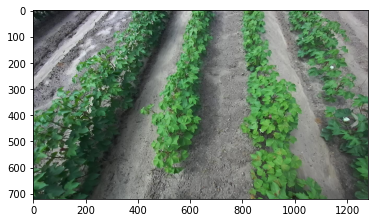

In [28]:
img = cv2.cvtColor(cv2.imread('../Cotton_data/071621/stereo_37_L.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

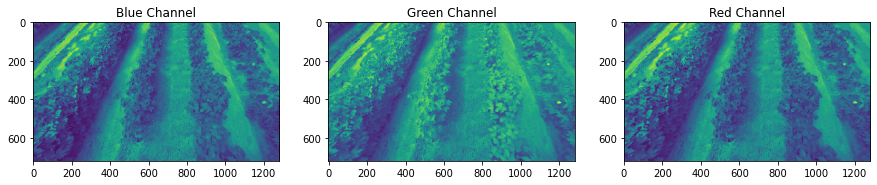

In [29]:
#splitting into channels
blue, green, red = cv2.split(img)
# Plotting the images
fig = plt.figure(figsize=(15, 7.2))
fig.add_subplot(131)
plt.title("Blue Channel")
plt.imshow(blue)
fig.add_subplot(132)
plt.title("Green Channel")
plt.imshow(green)
fig.add_subplot(133)
plt.title("Red Channel")
plt.imshow(red)
plt.show()

In [30]:
df_blue = blue/255
df_green = green/255
df_red = red/255

In [31]:
pca_b = PCA(n_components=100)
pca_b.fit(df_blue)
trans_pca_b = pca_b.transform(df_blue)
pca_g = PCA(n_components=100)
pca_g.fit(df_green)
trans_pca_g = pca_g.transform(df_green)
pca_r = PCA(n_components=100)
pca_r.fit(df_red)
trans_pca_r = pca_r.transform(df_red)

In [64]:
np.savez_compressed('saved_pca', b=np.float32(trans_pca_b), g=np.float32(trans_pca_g), r=np.float32(trans_pca_r))
np.savetxt('saved_pca_text_blue', np.float32(trans_pca_b))
#np.savetxt('saved_pca_text_green', trans_pca_g)
#np.savetxt('saved_pca_text_red', trans_pca_r)

In [65]:
print(np.float32(trans_pca_b).nbytes)
#but text file compressed is 770KB, still over. maybe due to additional spaces?
#npz is smaller than the 3 of them combined at ~788KB

288000


In [66]:
#printing out the variance accuracy/results
print(trans_pca_b.shape) #get the bits size of image from this
print(trans_pca_r.shape)
print(trans_pca_g.shape)

print(f"Blue Channel : {sum(pca_b.explained_variance_ratio_)}")
print(f"Green Channel: {sum(pca_g.explained_variance_ratio_)}")
print(f"Red Channel  : {sum(pca_r.explained_variance_ratio_)}")

(720, 100)
(720, 100)
(720, 100)
Blue Channel : 0.9433300932915508
Green Channel: 0.9293244630662093
Red Channel  : 0.9423775812014137


In [67]:
#reconstruct image and visualize by inversing
b_arr = pca_b.inverse_transform(np.float32(trans_pca_b))#trans_pca_b)
g_arr = pca_g.inverse_transform(np.float32(trans_pca_g))#trans_pca_g)
r_arr = pca_r.inverse_transform(np.float32(trans_pca_r))#trans_pca_r)
print(b_arr.shape, g_arr.shape, r_arr.shape)

(720, 1280) (720, 1280) (720, 1280)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(720, 1280, 3)


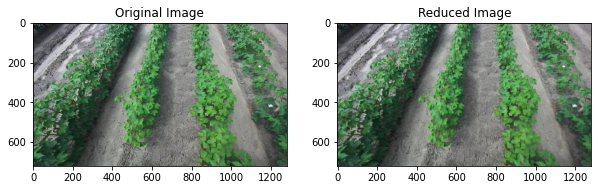

In [68]:
#merge all the channels into 1
img_reduced = (cv2.merge((b_arr, g_arr, r_arr)))
print(img_reduced.shape)

fig = plt.figure(figsize=(10, 7.2))
fig.add_subplot(121)
plt.title("Original Image")
plt.imshow(img)
fig.add_subplot(122)
plt.title("Reduced Image")
plt.imshow(img_reduced)
plt.show()

In [69]:
cv2.imwrite('stereo_37_L_r.jpg', img_reduced * 255)

True

In [70]:
#trying to inverse it to decompress the original image
compressed_np = np.load('saved_pca.npz')
blue_c = compressed_np['b']
green_c = compressed_np['g']
red_c = compressed_np['r']

In [71]:
b_arr_c = pca_b.inverse_transform(blue_c)
g_arr_c = pca_g.inverse_transform(green_c)
r_arr_c = pca_r.inverse_transform(red_c)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


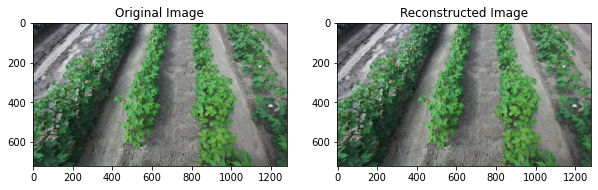

In [72]:
img_reconstruct = (cv2.merge((b_arr_c, g_arr_c, r_arr_c)))
fig = plt.figure(figsize=(10, 7.2))
fig.add_subplot(121)
plt.title("Original Image")
plt.imshow(img)
fig.add_subplot(122)
plt.title("Reconstructed Image")
plt.imshow(img_reconstruct)
plt.show()

In [78]:
img_reconstruct = (img_reconstruct * 255)
cv2.imwrite("stereo_37_L_reconstructed.jpg", img_reconstruct) #the reconstructed image that has all three channels
img_reconstruct = imread('stereo_37_L_reconstructed.jpg')

In [79]:
old = img.nbytes
new = np.float32(trans_pca_b).nbytes*3 # for reach of the three channels
print(old)
print(img_reconstruct.nbytes) # x8 the original amount because it's stored in floats (0.0-1.0) not ints (0-255)
                              # but can get it to original size by reloading from disk first in form of ints
print(new) 

# 0.625 expected
print("Percent Reduction: ", (old-new)/old * 100)
# in actuality, npz is 788KB or 1619000, but the image is compressed even more as JPEG... so not actually 68.75% reduction

2764800
2764800
864000
Percent Reduction:  68.75
